## Experiments

### Reading and processing data

In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

In [2]:
modalities = ["car", "shared-car", "public-transport", "bike"]

series_reporters = [
    *[f"monthly-{m}-trips" for m in modalities],
    "count cars",
    "shared-car-subscriptions",
    "public-transport-subscriptions",
    "mean-car-preference",
]

single_reporters = []

KPIs = series_reporters

In [3]:
replications = 7
months = 40

# exp_names = ["8-sc-default", "32-sc-22-pp-20p-removed", "128-sc-93-pp-40p-removed"]
exps = {
    "shared_cars_only": ["default", "shared-cars-mid", "shared-cars-high"],
    "parking_permit_only": ["default", "parking-permit-low", "parking-permit-high"],
    "remove_spots_only": ["default", "remove-spots-low", "remove-spots-high"],
    "parking_package": ["default", "parking-package-low", "parking-package-high"],
    "all": ["default", "all-low", "all-high"],
}
for k, v in exps.items():
    exps[k] = [f"{i}_{name}" for i, name in enumerate(v)]

# Create a flat list with all experiment names
exp_names = [item for sublist in exps.values() for item in sublist]
exp_names = list( dict.fromkeys(exp_names))
print(exp_names)

['0_default', '1_shared-cars-mid', '2_shared-cars-high', '1_parking-permit-low', '2_parking-permit-high', '1_remove-spots-low', '2_remove-spots-high', '1_parking-package-low', '2_parking-package-high', '1_all-low', '2_all-high']


In [4]:
# Read all the pickles into a dictionary of dataframes
dfs = {}
for i, name in enumerate(exp_names):
    dfs[name] = pd.read_pickle(f"../results/experiments-sharedprefext/exp_series_{name}_{replications}r_df.pickle")

### Statics (boxplots)

In [5]:
df_end = {}
for KPI in KPIs:
    df_end[KPI] = pd.DataFrame()
    for name, df in dfs.items():
        df_end[KPI][name] = df.iloc[months][KPI]
df_end["count cars"].head(3)

,0_default,1_shared-cars-mid,2_shared-cars-high,1_parking-permit-low,2_parking-permit-high,1_remove-spots-low,2_remove-spots-high,1_parking-package-low,2_parking-package-high,1_all-low,2_all-high
0,413.0,429.0,505.0,343.0,324.0,350.0,272.0,304.0,209.0,342.0,319.0
1,365.0,415.0,501.0,297.0,263.0,365.0,262.0,288.0,258.0,284.0,318.0
2,358.0,372.0,470.0,320.0,307.0,349.0,265.0,274.0,200.0,317.0,291.0


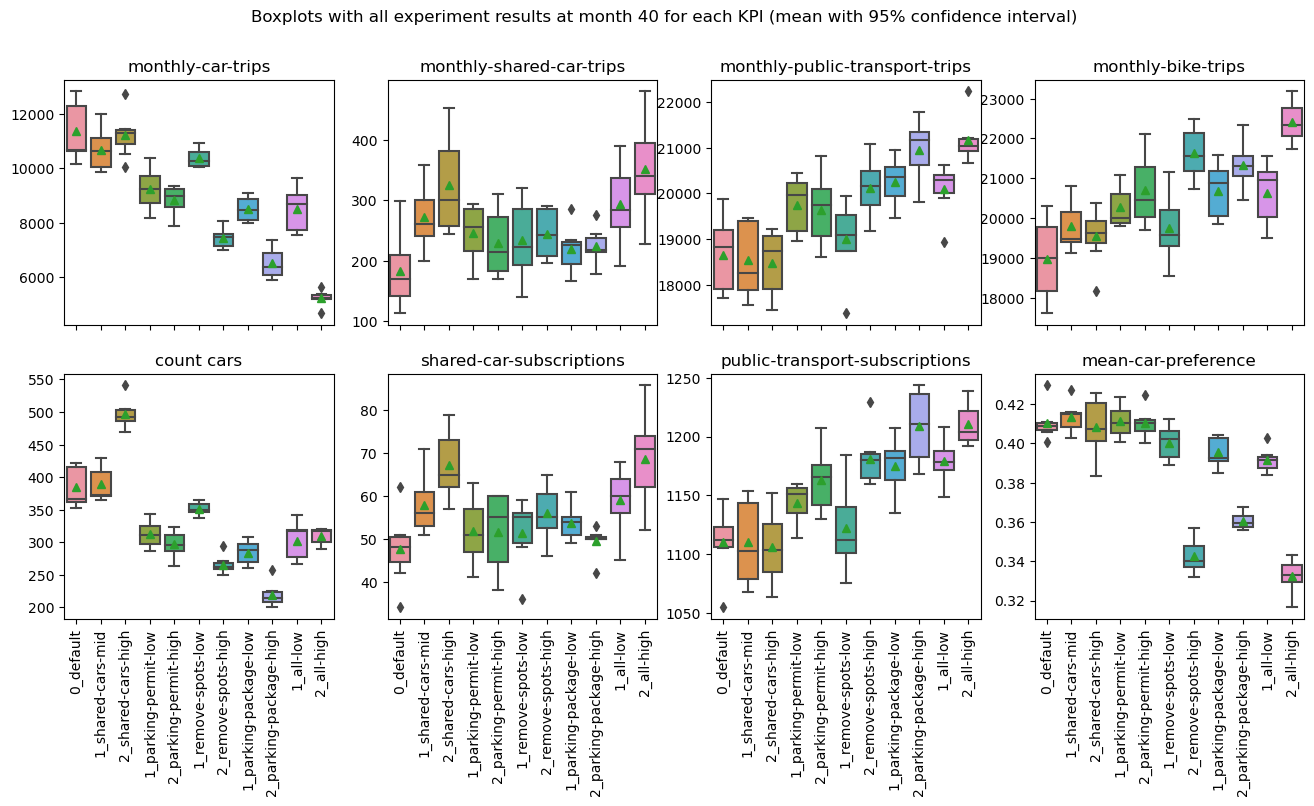

In [6]:
fig, axes = plt.subplots(2,4)
fig.set_size_inches(16,7)
g = {}
for i, KPI in enumerate(KPIs):
    g[KPI] = sns.boxplot(df_end[KPI], showmeans=True, ax=axes.flat[i])
    if i <= 3:
        g[KPI].set_xticklabels("")
    g[KPI].set_xticklabels(g[KPI].get_xticklabels(), rotation=90)
    g[KPI].set_title(KPI)
fig.suptitle(f'Boxplots with all experiment results at month {months} for each KPI (mean with 95% confidence interval)')
fig.savefig("../images-sharedprefext/exp_boxplots.svg", bbox_inches='tight')

### Dynamics

In [7]:
# Create an empty DataFrame for each KPI
dy_dict = {}
for KPI in KPIs:
    dy_dict[KPI] = pd.DataFrame()

# For each experiment, add a data column to the dataframe of each KPI
for i, exp in enumerate(exp_names):
    df_t = dfs[exp].sort_index(axis="columns", level=0)
    for KPI in KPIs:
        dy_dict[KPI][exp] = df_t[KPI].unstack()
dy_dict[KPIs[0]].head()

0_default  1_shared-cars-mid  2_shared-cars-high  1_parking-permit-low  \
0 0        0.0                0.0                 0.0                   0.0   
  1    25703.0            26038.0             25966.0               25552.0   
  2    22965.0            23792.0             23607.0               22508.0   
  3    20568.0            21428.0             21528.0               19651.0   
  4    18977.0            19639.0             19881.0               17564.0   

     2_parking-permit-high  1_remove-spots-low  2_remove-spots-high  \
0 0                    0.0                 0.0                  0.0   
  1                26318.0             23173.0              21371.0   
  2                23435.0             21174.0              19783.0   
  3                20749.0             18926.0              17602.0   
  4                18741.0             17326.0              15846.0   

     1_parking-package-low  2_parking-package-high  1_all-low  2_all-high  
0 0                    0.0                     0.0        0.0         0.0  
  1                23870.0                 20799.0    22853.0     21009.0  
  2                21778.0                 18185.0    21247.0     19090.0  
  3                19469.0                 15782.0    19139.0     16456.0  
  4                17141.0                 13911.0    17362.0     14339.0

Finished plot shared_cars_only.
Finished plot parking_permit_only.
Finished plot remove_spots_only.
Finished plot parking_package.
Finished plot all.


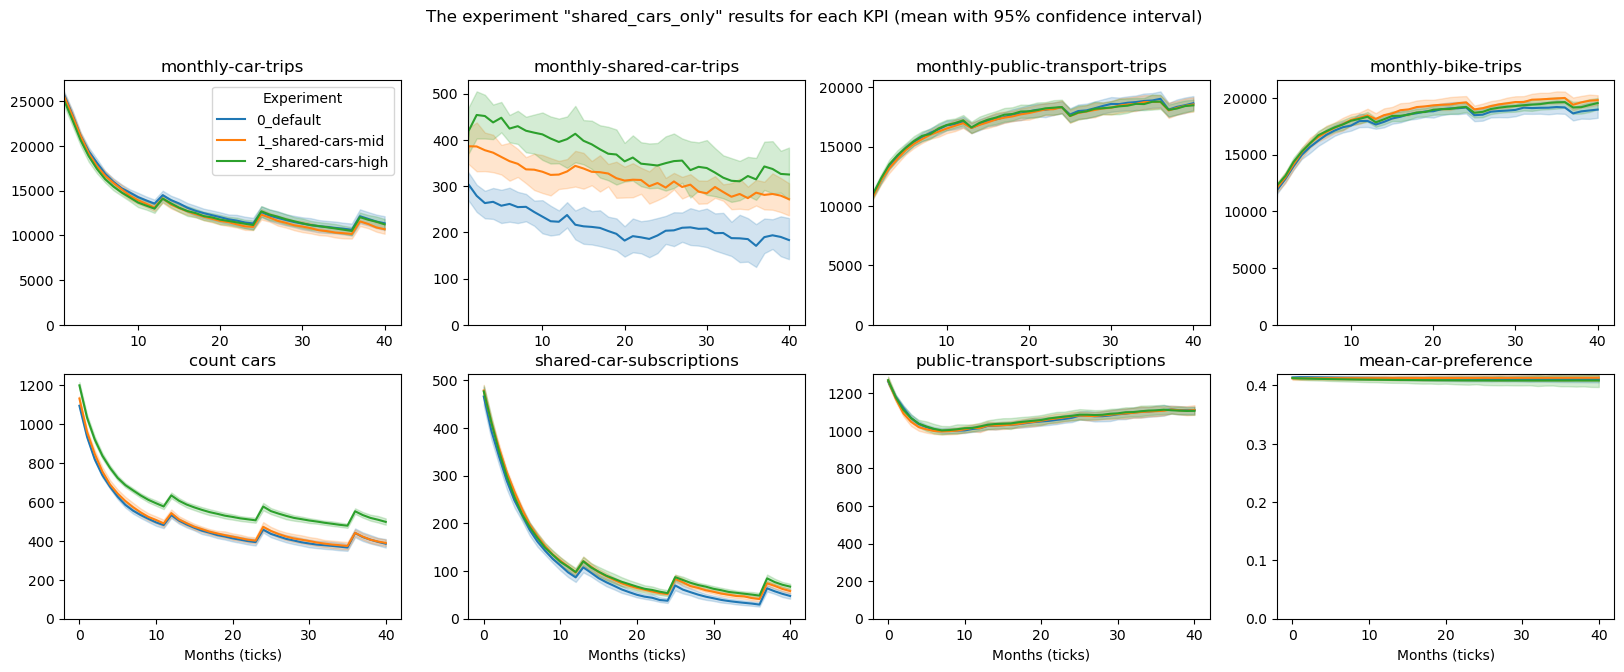

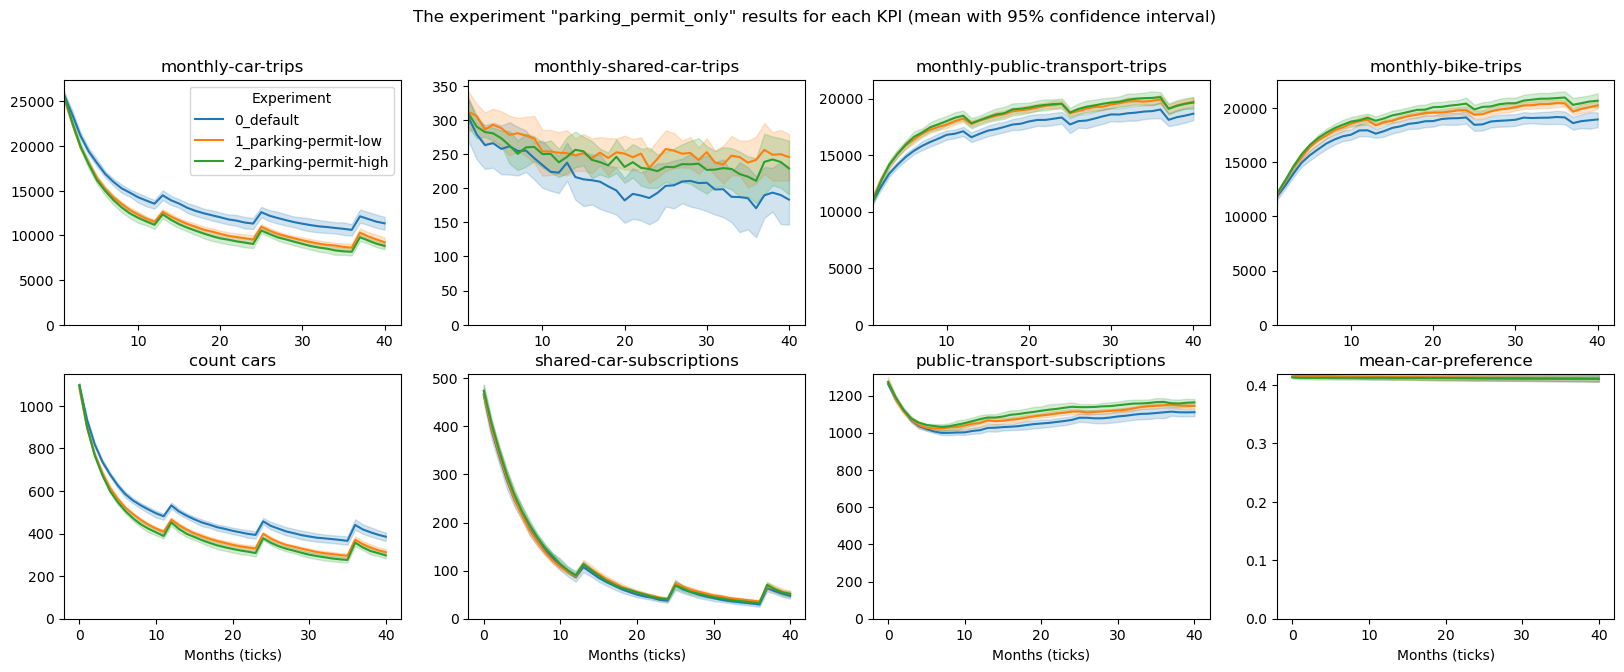

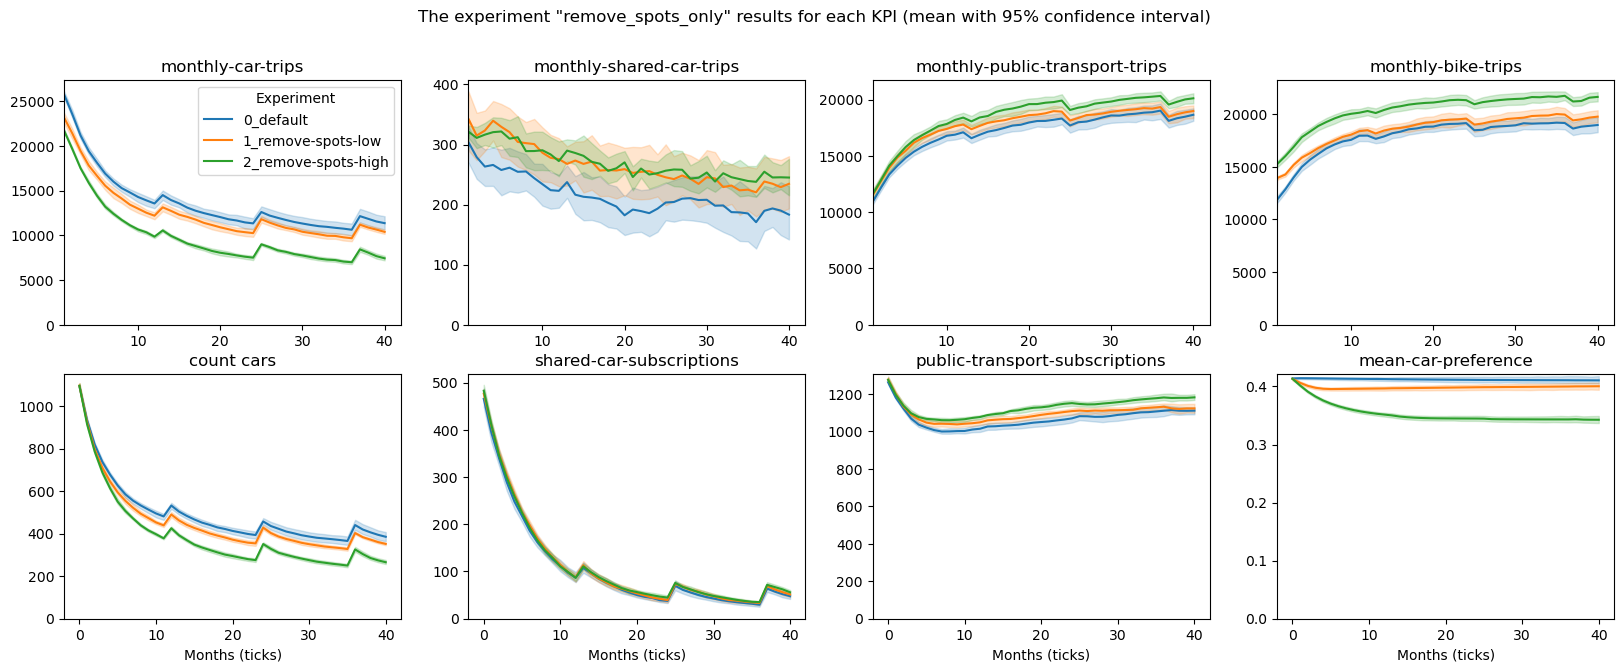

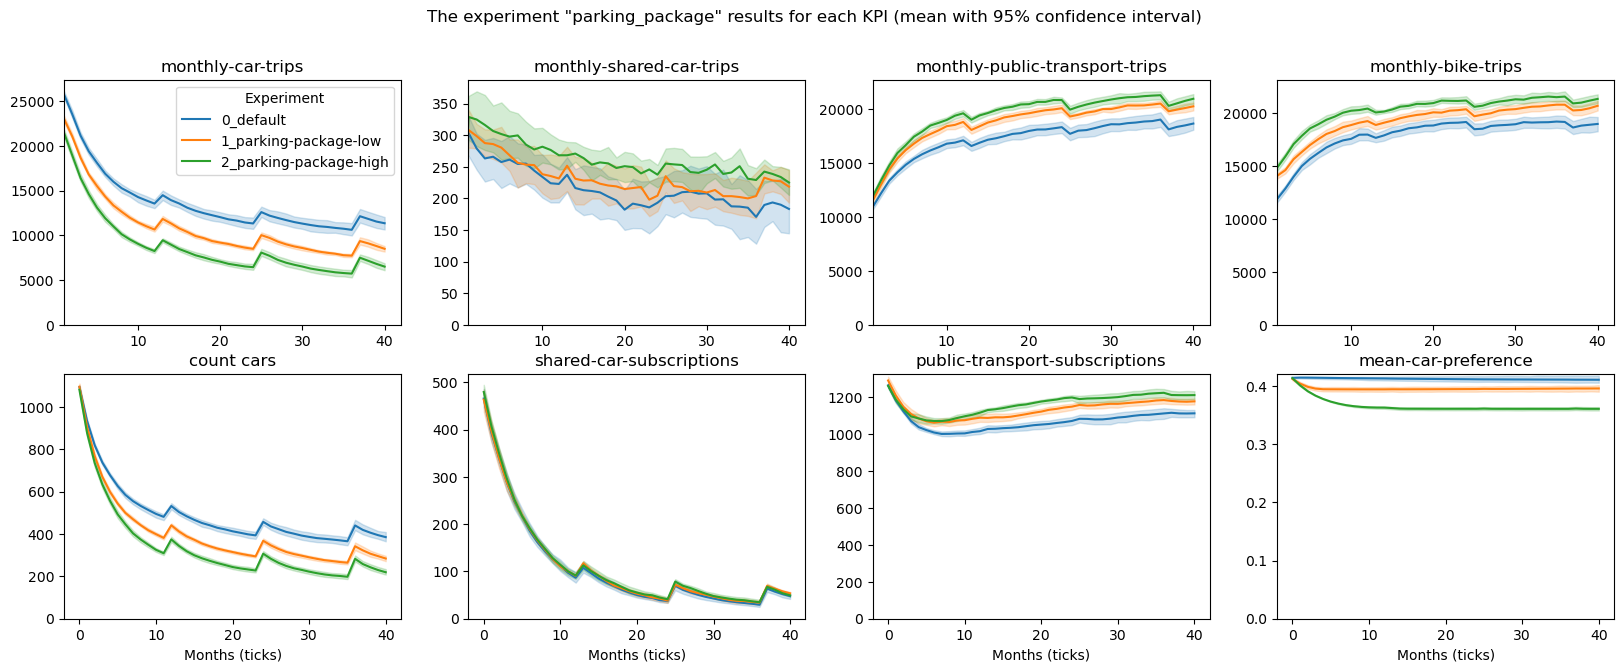

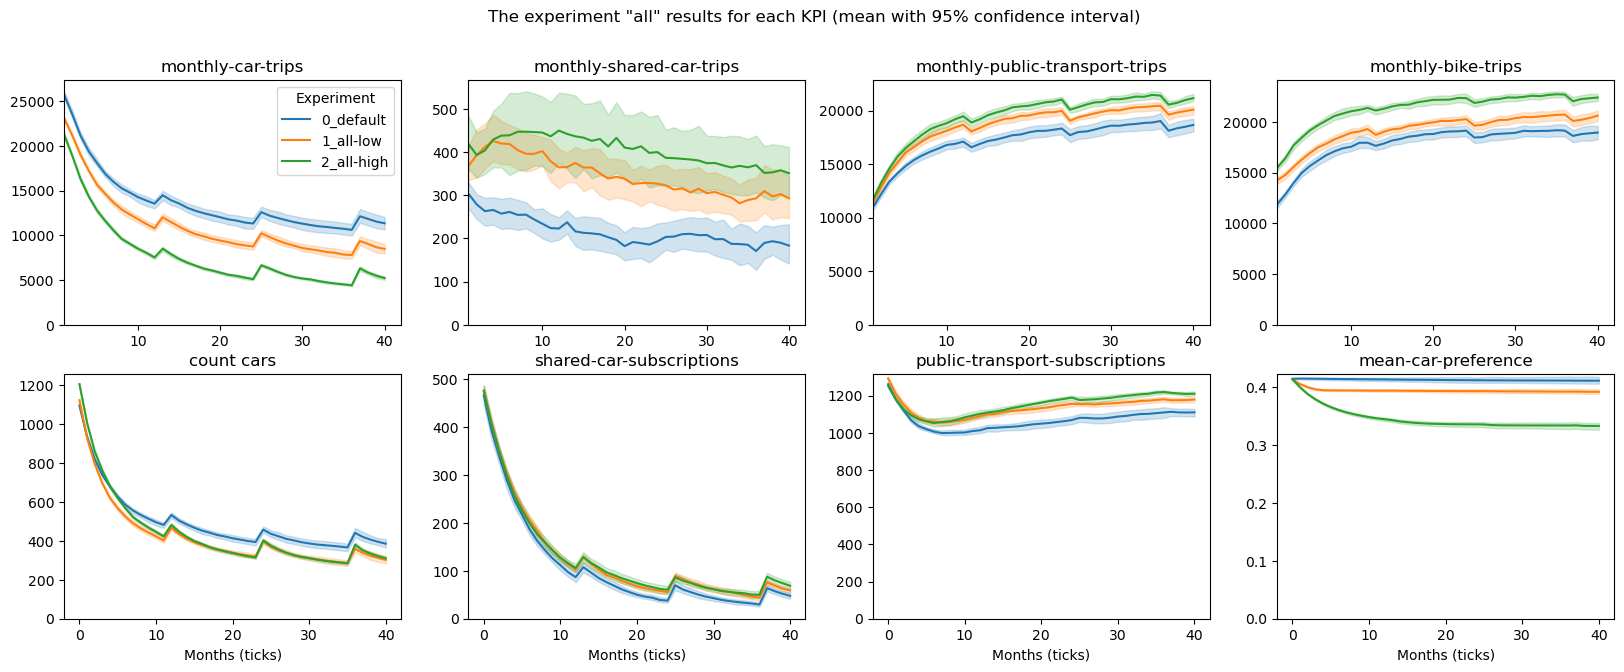

In [8]:
# Plot a lineplot for each KPI with seaborn
# This cell takes a long time, 2 to 3 minutes (probably because of the confidence interval calculation
to_plot = True # Set True to run this complicated plot
if to_plot:
    for plot_name, exp_names_t in exps.items():
        # Create a figure and axis
        fig, axes = plt.subplots(2,4)
        fig.set_size_inches(20,7)

        g = {}
        for i, KPI in enumerate(KPIs):
            # Select the DataFrame each KPI, and select the columns for this experiment
            df_t = dy_dict[KPI][exp_names_t]
            # Unstack the dataframe and rename the columns
            df_t = df_t.T.unstack().reset_index()
            df_t.columns = ["Reps", "Ticks", "Experiment", "Data"]

            # Create the lineplot with confidence intervals and save as SVG
            g[KPI] = sns.lineplot(df_t, x="Ticks", y="Data", hue="Experiment", errorbar=("ci", 95), ax=axes.flat[i])
            g[KPI].set_title(f"{KPI}")
            g[KPI].set_ylim(bottom=0)
            # Set xlabel for the bottom row
            if i >= 4:
                g[KPI].set_xlabel("Months (ticks)")
            else:
                g[KPI].set_xlabel("")
            g[KPI].set_ylabel("")
            # Remove the legend except the fourth plot
            if i != 0:
                g[KPI].legend_.remove()
            # Drop the first row for all the trip KPIs, since in month 0 no trips have been made
            if i <= 3:
                g[KPI].set_xlim(left=1)
        fig.suptitle(f'The experiment "{plot_name}" results for each KPI (mean with 95% confidence interval)')
        fig.savefig(f"../images-sharedprefext/exp_{plot_name}_lineplots.svg", bbox_inches="tight")
        print(f"Finished plot {plot_name}.")